# APS 3

___

## <font style='font-family:Georgia' color='teal'> Estudo de uma treliça plana</font> 


####  <font style='font-family:Georgia' color='darkturquoise'> André Tavernaro || Antonio Fuziy || Gabriela Mitu || Gabriella Cukier</font> 

### Importando bibliotecas e valores

In [1]:
from funcoesTermosol import *
import numpy as np
import math

### Representação da estrutura

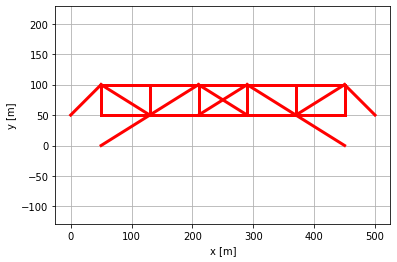

In [7]:
entrada = "entrada.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [9]:
# Comprimento 
L = 5
#numero de nodes
n = 16

### Gerando a matriz de conectividade transposta

In [10]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
C_t

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0,
         0,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0, -1],
       [ 0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,
         0,  0, -1,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1, 

### Matriz dos membros (M)

In [11]:
M = np.matmul(N, C_t)
print(M)

[[ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  50.  80.  80.  80.
   80.  80.  50.  80.  80.   0.   0.   0.   0.   0.   0.  80.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  50. -50.  50. -50.
  -50.  50. -50.  50. -50.  50. -50. -50. -50. -50. -50.  50.]]


### Obtendo Se, Ke e Kg

In [12]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 5656.85424949  5656.85424949     0.         ...     0.
      0.             0.        ]
 [ 5656.85424949  5656.85424949     0.         ...     0.
      0.             0.        ]
 [    0.             0.         10000.         ...     0.
      0.             0.        ]
 ...
 [    0.             0.             0.         ...  2382.01770788
      0.             0.        ]
 [    0.             0.             0.         ...     0.
   6097.9653337  -3811.22833356]
 [    0.             0.             0.         ...     0.
  -3811.22833356  2382.01770847]]


### Deslocamento nodal

Aplicando as condições de contorno para a matriz das forças:

In [13]:
F_c = np.delete(F, R.astype(int))
F_c


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       75.,  0., 75.,  0.,  0.,  0.,  0.])

Aplicando as condições de contorno para a matriz da rigidez:

In [14]:
Kg_c = np.delete(Kg, R.astype(int),0)
Kg_c = np.delete(Kg_c, R.astype(int), 1)
Kg_c

array([[ 3.82938960e+04,  3.81122833e+03, -1.00000000e+04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -6.09796533e+03,
         3.81122833e+03,  0.00000000e+00,  0.00000000e+00,
        -6.09796533e+03, -3.81122833e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.81122833e+03,  2.31460531e+04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.81122833e+03,
        -2.38201771e+03,  0.00000000e+00, -1.60000000e+04,
        -3.81122833e+03, -2.38201771e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+04,  0.00000000e+00,  2.60979653e+04,
         3.81122834e+03, -1.00000000e+04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

___
**Funções de Jacobi e Gauss-Seidel utilizadas na aula 21:**

In [15]:
def jacobi(k,F,ite,tol):
    #inicializando X com 
    x = np.zeros(k.shape[0])

    # Cria um vetor com os elementos da diagonal de k                       
    diagonal = np.diag(k)
    # Subtrai a diagonal de K
    k_d = k - np.diagflat(diagonal)
    # loop até chegar abaixo da tolerância ou passar do número máximo de iterações
    for i in range(ite):
        x2 = (F - np.matmul(k_d,x)) / diagonal
        error =  max(abs((x2 - x)/x2) )
        if error < tol:
            print(f"Erro máximo: {error}")
            print(f"Convergiu na iteração: {i}")
            return x2
        
        x = x2
    return x

In [16]:
def gauss_seidel(A, b, ite, tol):
    x = np.zeros_like(b, dtype=np.double)
    
    #Iterate
    for k in range(ite):
        
        x_old  = x.copy()
        
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
        #Stop condition 
        if np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) < tol:
            break
            
    return x

___
Utilizando Jacobi, Gauss-Seidel e a forma geral para cálculo da matriz **U**

In [17]:
u_jacobi = jacobi(Kg_c, F_c, 100, 1e-5)

<ipython-input-15-262c35adf621>:12: RuntimeWarning: invalid value encountered in true_divide
  error =  max(abs((x2 - x)/x2) )


In [18]:
u_jacobi

array([-1.09593264,  0.4288049 ,  4.63496717,  7.79522066, -4.63496716,
        7.79522066,  1.09593264,  0.4288049 ,  1.1802917 , -0.11080247,
       -2.03369068, -0.35366354,  3.27043316, -6.80127024, -3.27043316,
       -6.80127024,  2.03369068, -0.35366354, -1.1802917 , -0.11080247])

In [19]:
u_gauss = gauss_seidel(Kg_c, F_c, 100, 1e-5)

In [20]:
u_gauss

array([ 0.00292797,  0.02100353,  0.00160035,  0.06590212, -0.00160111,
        0.06590435, -0.00292881,  0.02100668, -0.00546208,  0.00203639,
       -0.00528966,  0.02100353, -0.00511886,  0.06519501,  0.00511447,
        0.06519685,  0.00528705,  0.02100668,  0.00546219,  0.00203658])

**Deslocamentos nodais**

In [21]:
U_ar = np.linalg.solve(Kg_c, F_c)
U_ar

array([ 0.00293888,  0.02118023,  0.00160656,  0.06634306, -0.00160656,
        0.06634306, -0.00293888,  0.02118023, -0.00551161,  0.00205597,
       -0.00533081,  0.02118023, -0.00515001,  0.06560838,  0.00515001,
        0.06560838,  0.00533081,  0.02118023,  0.00551161,  0.00205597])

**Ajustando o tamanho das matrizes U**

In [22]:
u_jacobi_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_jacobi_ajustado)):
    if e not in R:
        u_jacobi_ajustado[e] += u_jacobi[i]
        i += 1
u_jacobi_ajustado

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-1.09593264],
       [ 0.4288049 ],
       [ 4.63496717],
       [ 7.79522066],
       [-4.63496716],
       [ 7.79522066],
       [ 1.09593264],
       [ 0.4288049 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 1.1802917 ],
       [-0.11080247],
       [-2.03369068],
       [-0.35366354],
       [ 3.27043316],
       [-6.80127024],
       [-3.27043316],
       [-6.80127024],
       [ 2.03369068],
       [-0.35366354],
       [-1.1802917 ],
       [-0.11080247],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [23]:
u_gauss_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_gauss_ajustado)):
    if e not in R:
        u_gauss_ajustado[e] += u_gauss[i]
        i += 1
u_gauss_ajustado

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.00292797],
       [ 0.02100353],
       [ 0.00160035],
       [ 0.06590212],
       [-0.00160111],
       [ 0.06590435],
       [-0.00292881],
       [ 0.02100668],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.00546208],
       [ 0.00203639],
       [-0.00528966],
       [ 0.02100353],
       [-0.00511886],
       [ 0.06519501],
       [ 0.00511447],
       [ 0.06519685],
       [ 0.00528705],
       [ 0.02100668],
       [ 0.00546219],
       [ 0.00203658],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [24]:
u = np.zeros((nn*2,1))
i = 0
for e in range(len(u)):
    if e not in R:
        u[e] += U_ar[i]
        i += 1
u

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.00293888],
       [ 0.02118023],
       [ 0.00160656],
       [ 0.06634306],
       [-0.00160656],
       [ 0.06634306],
       [-0.00293888],
       [ 0.02118023],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.00551161],
       [ 0.00205597],
       [-0.00533081],
       [ 0.02118023],
       [-0.00515001],
       [ 0.06560838],
       [ 0.00515001],
       [ 0.06560838],
       [ 0.00533081],
       [ 0.02118023],
       [ 0.00551161],
       [ 0.00205597],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

### Reações de apoio

In [25]:
P = np.matmul(Kg,u)
P

array([[ 1.95480493e+01],
       [ 1.95480493e+01],
       [-2.93888499e+01],
       [-3.28955936e+01],
       [ 0.00000000e+00],
       [-7.99360578e-14],
       [ 4.21884749e-14],
       [ 1.19015908e-13],
       [ 7.77156117e-14],
       [ 7.10542736e-15],
       [-2.84217094e-14],
       [ 7.46069873e-14],
       [ 2.93888499e+01],
       [-3.28955936e+01],
       [-1.95480493e+01],
       [ 1.95480493e+01],
       [ 0.00000000e+00],
       [ 1.50990331e-14],
       [-1.42108547e-14],
       [ 5.68434189e-14],
       [-8.52651283e-14],
       [ 7.50000000e+01],
       [-5.68434189e-14],
       [ 7.50000000e+01],
       [ 0.00000000e+00],
       [-1.13686838e-13],
       [-1.42108547e-14],
       [-2.28705943e-14],
       [-9.86439291e+01],
       [-6.16524557e+01],
       [ 9.86439291e+01],
       [-6.16524557e+01]])

In [26]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[ 19.54804934],
       [ 19.54804934],
       [-29.38884989],
       [-32.89559362],
       [-98.64392914],
       [-61.65245572],
       [ 29.38884989],
       [-32.89559363],
       [-19.54804934],
       [ 19.54804934],
       [ 98.64392915],
       [-61.65245572]])

### Deformações, Tenões e Forças internas

In [27]:
deformacoes=[]
tensoes=[]
forcas=[]
for i in range (nm):
        
    matriz = [
            u[(int(Inc[i, 0])-1)*2], 
            u[(int(Inc[i, 0])-1)*2 +1], 
            u[(int(Inc[i, 1])-1)*2], 
            u[int(Inc[i, 1]-1)*2 +1]
    ]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))  
    
    E =  Inc[i, 2]
    A = Inc[i,3]
    const = E*A/L
    
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]

    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)



In [28]:
deformacoes

[array([3.67360624e-05]),
 array([-1.66541148e-05]),
 array([-4.01638952e-05]),
 array([-1.66541148e-05]),
 array([3.67360624e-05]),
 array([2.26002689e-06]),
 array([2.26002689e-06]),
 array([0.00012875]),
 array([2.26002689e-06]),
 array([2.26002689e-06]),
 array([-3.45563956e-05]),
 array([-3.14801202e-05]),
 array([0.00017689]),
 array([2.77238531e-05]),
 array([0.00017689]),
 array([-3.14801202e-05]),
 array([-3.45563956e-05]),
 array([0.00014541]),
 array([0.00014541]),
 array([4.1119492e-05]),
 array([6.9388939e-20]),
 array([-1.46936127e-05]),
 array([-1.46936127e-05]),
 array([-1.38777878e-19]),
 array([4.1119492e-05]),
 array([2.7723853e-05])]

In [29]:
tensoes

[array([146944.24944765]),
 array([-66616.45909275]),
 array([-160655.58071734]),
 array([-66616.45908344]),
 array([146944.24944589]),
 array([9040.10757009]),
 array([9040.10757009]),
 array([515000.98592688]),
 array([9040.10754216]),
 array([9040.10754216]),
 array([-138225.582473]),
 array([-125920.48093243]),
 array([707548.58489327]),
 array([110895.41239617]),
 array([707548.58491522]),
 array([-125920.4809259]),
 array([-138225.58250467]),
 array([581628.10396084]),
 array([581628.10398932]),
 array([164477.96811899]),
 array([2.77555756e-10]),
 array([-58774.45101537]),
 array([-58774.45102119]),
 array([-5.55111513e-10]),
 array([164477.96813793]),
 array([110895.41238519])]

In [30]:
forcas

[array([29.38884989]),
 array([-13.32329182]),
 array([-32.13111614]),
 array([-13.32329182]),
 array([29.38884989]),
 array([1.80802151]),
 array([1.80802151]),
 array([103.00019719]),
 array([1.80802151]),
 array([1.80802151]),
 array([-27.64511649]),
 array([-25.18409619]),
 array([141.50971698]),
 array([22.17908248]),
 array([141.50971698]),
 array([-25.18409619]),
 array([-27.6451165]),
 array([116.32562079]),
 array([116.3256208]),
 array([32.89559362]),
 array([5.55111513e-14]),
 array([-11.7548902]),
 array([-11.7548902]),
 array([-1.11022303e-13]),
 array([32.89559363]),
 array([22.17908248])]

___
**Gerando Saídas com as 3 matrizes U calculadas anteriormente**

In [31]:
geraSaida("geral", P_r, u, deformacoes, forcas, tensoes)

In [32]:
geraSaida("jacobi", P_r, u_jacobi_ajustado, deformacoes, forcas, tensoes)

In [33]:
geraSaida("gauss", P_r, u_gauss_ajustado, deformacoes, forcas, tensoes)